In [1]:
import numpy as np
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import sys
sys.path.append('../')

from Algorithms import incremental_greedy,no_step_greedy_ball
from utils import RandomUnifBall, verify_feasibility

from UpperBounds import reverse_upperbound_stepped,reverse_upperbound_no_step,relaxed_convex_upperbound

import RKHS
from RKHS import GPMI,Gram

import cvxpy as cp

import pickle as pkl
%load_ext autoreload
%autoreload 2

# Experiment parameters

In [40]:
T = 60

c = 1
l = 1
var_0 = 0.01


search_region_center = np.array([0.,0.])
search_region_radius = 1
step_size = 1

x0 = search_region_center

# Callables

In [41]:

x_objective = partial(GPMI,c=c,l=l,var_0=var_0)

kernel = partial(RKHS.k,c=c,l=l)


# Different benchmark algorithms, call as needed.

In [42]:
Ts = np.arange(1,T+1,10)

In [43]:
seed = 0
np.random.seed(seed)

greedy_val = []

reverse_no_step = []

reverse_step = []

convex = []
T_max = 2*T



print('Search Region Radius',search_region_radius)
# The reference system.

ref = np.array([[0,0]]) # A single point reference set.
R = np.array([search_region_radius*np.ones(T_max)]).T


N = len(ref)

greedy = incremental_greedy(kernel,x0,step_size,ref,R,T_max,var_0,c)

greedy_no_step = no_step_greedy_ball(kernel,x0,search_region_radius,T_max,var_0,c)

reverse_no_step = reverse_upperbound_no_step(x_objective,kernel,greedy_no_step,T)

Search Region Radius 1


In [44]:
for t in Ts:
    print(t)
    ref = np.array([[0,0]]) # A single point reference set.
    R = np.array([search_region_radius*np.ones(t)]).T


    rs = reverse_upperbound_stepped(x_objective,kernel,greedy[:2*t],search_region_center,search_region_radius,c,var_0,step_size,t)
    reverse_step.append(rs)
    
    cv = relaxed_convex_upperbound(step_size,c,l,var_0,kernel,ref,R,t,search_region_radius)
    convex.append(cv)


1
11
21
31
41
51


In [45]:
greedy_val = [x_objective(greedy[0:t]) for t in Ts]

# Plotting

In [46]:
results = {'Greedy Value':(greedy_val,None),
          'Convex Relaxation':(convex,'dashed'),
          'Reverse bound-no Step Constraint':(reverse_no_step[Ts],'dashed'),
          'Reverse bound-with Step Constraint':(reverse_step,'dashed')
          }

In [47]:
min_upperbound = np.min([convex,list(reverse_no_step[Ts]),reverse_step],axis=0)

In [48]:
results['Min of upperbounds']=(min_upperbound,None)

# Pickle the results

In [50]:

data = {'results':results,'SEED':seed,'T':T,'Ts':Ts,
        'search_region_radius':search_region_radius,'search_region_center':search_region_center,
        'c':c,'l':l,'var_0':var_0,
        'step_size':step_size
       }
with open('UpperboundsR-{}-T-{}.pkl'.format(search_region_radius,T),'wb') as file:
    pkl.dump(data,file)

Greedy Value 6
Convex Relaxation 6
Reverse bound-no Step Constraint 6
Reverse bound-with Step Constraint 6
Min of upperbounds 6


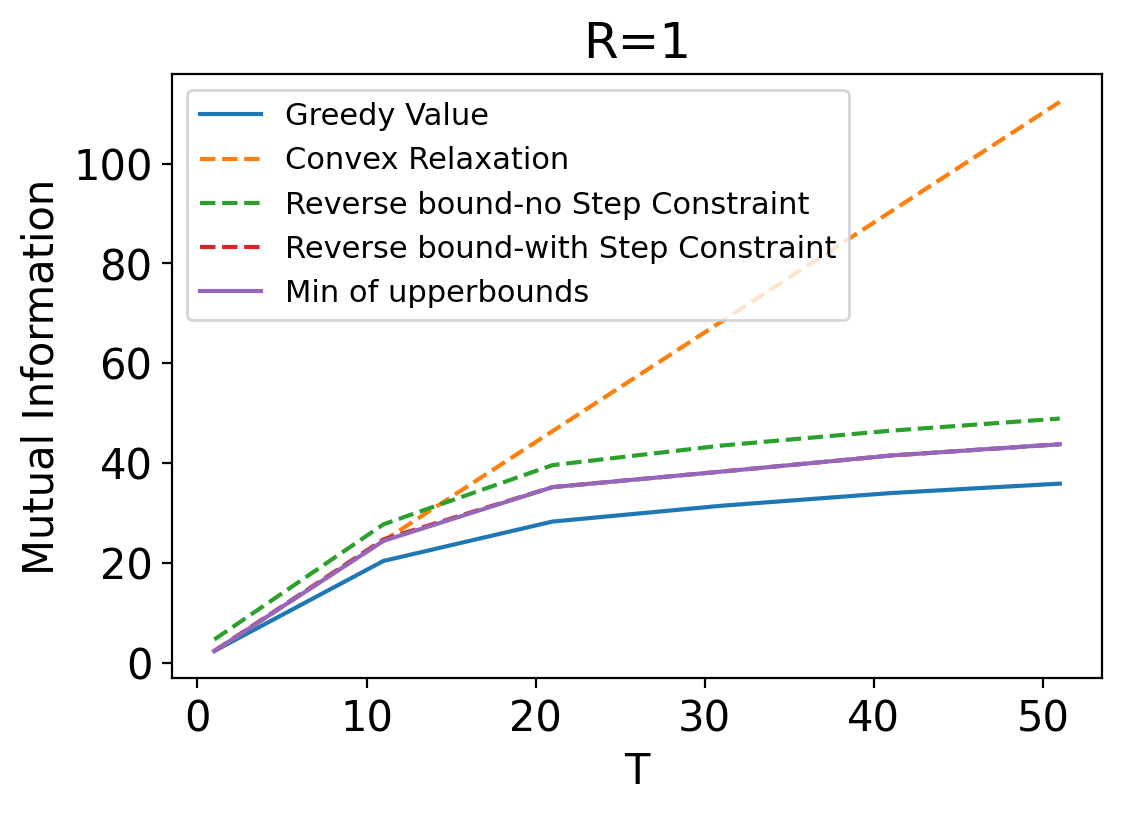

<Figure size 432x288 with 0 Axes>

In [51]:
results = data['results']
Ts = np.arange(1,60,10)
plt.figure(dpi=200)
plt.rc('font',size=15)
for key,val in results.items():
    print(key,len(val[0]))
    plt.plot(Ts,val[0],label = key,ls=val[1])
    plt.xlabel('T')
    plt.ylabel('Mutual Information')
    
plt.title('R={}'.format(search_region_radius))
plt.legend(prop={'size':11})
plt.show()
plt.tight_layout()

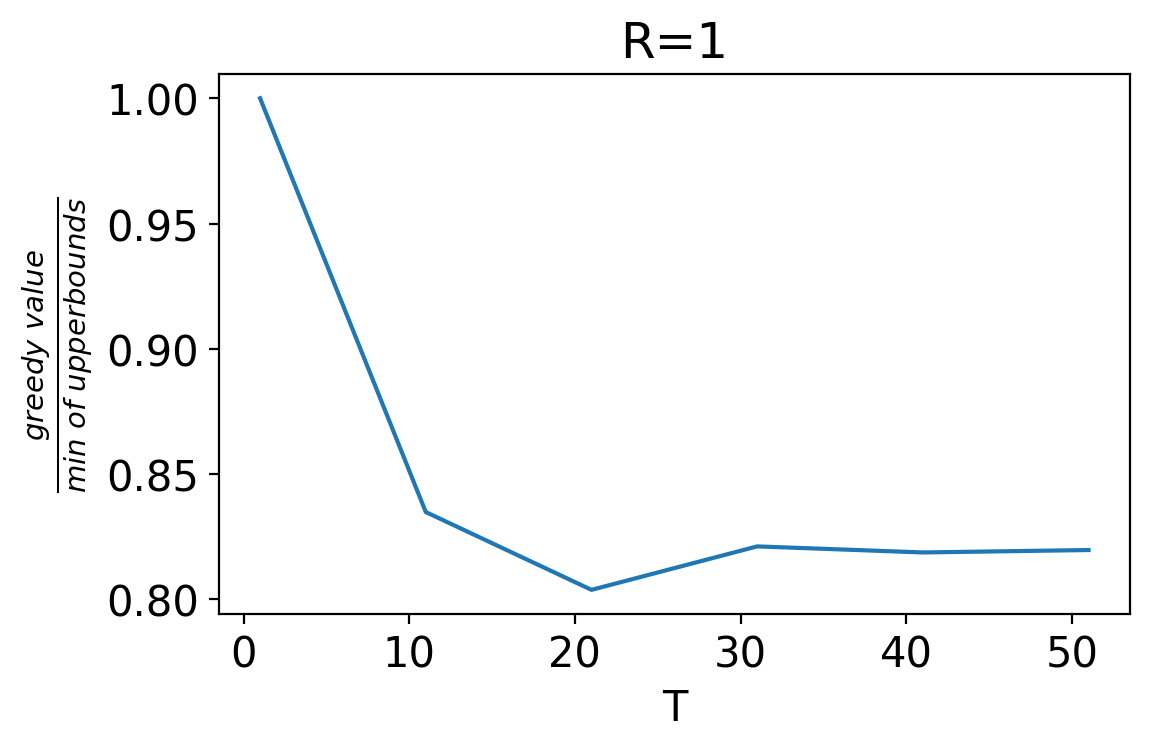

In [52]:
plt.figure(dpi=200)

plt.rc('font',size=15)
plt.plot(Ts,greedy_val/min_upperbound)
plt.xlabel('T')
plt.ylabel(r'$\frac{greedy~value}{min~of~upperbounds}$')

plt.title('R={}'.format(search_region_radius))
plt.tight_layout()